# Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

# Required Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin, sqrt
from pathlib import Path
import pandas as pd
import seaborn as sns
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

# Dowload Data into google drive
to use it again without downloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip -P /content/drive/MyDrive/

Mounted at /content/drive


# Download data directly into notebook

In [ ]:
# link of the data
# !wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

# Load data

In [ ]:
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  in

# Utility functions

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    """
    tdx, tdy : axis position coordinates
    size : size of the axis
    """

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## **<font style="color:rgb(134,19,348)">Initialize the Face Pose Detection Model</font>**

The first thing that we need to do is initialize the face pose class using the **`mediapipe.solutions.face_mesh`** as faceModule and then we will call the setup function **`faceModule.FaceMesh()`** with the arguments:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the detector is only invoked as needed, that is in the very first frame or when the tracker loses track. If set to `True`, the person detector is invoked on every input image. So you should probably set this value to True when working with a bunch of unrelated images not videos. Its default value is `False`.

* **`min_detection_confidence`** - It is the minimum detection confidence with range `(0.0 , 1.0)` required to consider the person-detection model's prediction correct. Its default value is `0.5`. This means if the detector has a prediction confidence of greater or equal to 50% then it will be considered as a positive detection.


* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` required to consider the landmark-tracking model's tracked pose landmarks valid. If the confidence is less than the set value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is `0.5`.


* **`model_complexity`** - It is the complexity of the pose landmark model. As there are three different models to choose from so the possible values are `0`, `1`, or `2`. The higher the value, the more accurate the results are, but at the expense of higher latency. Its default value is `1`.


* **`smooth_landmarks`** - It is a boolean value that is if set to `True`, pose landmarks across different frames are filtered to reduce noise. But only works when **`static_image_mode`** is also set to `False`. Its default value is `True`.


But here we used **`static_image_mode`** only

In [ ]:
def fetch(data_dir):
  """
  data_dir : directory of data to fetch their images with their corresponding
  landmarks and angles

  RETURNS : images in the directory their corresponding
  landmarks and angles respectively
  """
  if not data_dir.endswith('/'):
    data_dir += '/'

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its corresponding mat file
  images = []
  landmarks = []
  angles = []
  with faceModule.FaceMesh(static_image_mode=True) as faces:

      for file in sorted(os.listdir(data_dir)):
        if not file.endswith('.jpg'):
          continue
                  
        landmarks_per_image = []
        
        file = file.split('.')[0]

        # loading the image
        image = cv2.imread(data_dir+file+'.jpg')

        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  landmarks_per_image.append(relative_x)
                  landmarks_per_image.append(relative_y)

        # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)        
        mat_file = sio.loadmat(data_dir+file+'.mat')
        # extracting the labels 3 angels
        pose_para = mat_file["Pose_Para"][0][:3]

        images.append(image)
        landmarks.append(landmarks_per_image)
        angles.append(pose_para)
  
  return images, landmarks, angles

Now we will pass the image to the pose detection machine learning pipeline by using the function **`mediapipe.solutions.face_mesh.FaceMesh().process()`**. But the pipeline expects the input images in **`RGB`** color format so first we will have to convert the sample image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format (instead of **`RGB`**).

After performing the pose detection, we will get a list of thirty-three landmarks representing the body joint locations of the prominent person in the image. Each landmark has:

* **`x`** - It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.


* **`y`**: It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.


* **`z`**: It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with midpoint of hips being the origin, so the smaller the value of z, the closer the landmark is to the camera. 

* **`visibility`**: It is a value with range [0.0, 1.0] representing the possibility of the landmark being visible (not occluded) in the image. This is a useful variable when deciding if you want to show a particular joint because it might be occluded or partially visible in the image.

But here we used **`x, y`** landmarks only

In [ ]:
def get_features(image):
  """
  image : image that its corresponding landmarks will be fetched

  RETURNS : landmarks of the image
  """
  landmarks = []
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  landmarks.append(relative_x)
                  landmarks.append(relative_y)
  landmarks = np.array(landmarks).reshape(1, -1)
  return landmarks

# Preparing Data

In [ ]:
images, landmarks, angles = fetch('/content/AFLW2000')

##### Chech images, landamrks and angles have the same size, as every landmark, angle maps for 1 image

In [ ]:
print('images:', len(images))
print('landmarks:', len(landmarks))
print('angles:', len(angles))

images: 2000
landmarks: 2000
angles: 2000


In [ ]:
landmarks_df = pd.DataFrame(landmarks)
landmarks_df.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,251.0,218.0,246.0,221.0,243.0,225.0,299.0,212.0,304.0,208.0
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,235.0,228.0,230.0,230.0,225.0,231.0,263.0,225.0,267.0,222.0
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,150.0,323.0,148.0,324.0,147.0,325.0,168.0,320.0,169.0,319.0
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,228.0,225.0,223.0,229.0,220.0,233.0,268.0,205.0,271.0,200.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Rename columns for better visualization

In [ ]:
for i in range(0, len(landmarks_df.columns), 2):
  landmarks_df.rename(columns={landmarks_df.columns[i]: f'X {i//2}'}, inplace=True)
  landmarks_df.rename(columns={landmarks_df.columns[i+1]: f'Y {i//2}'}, inplace=True)

In [ ]:
landmarks_df.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 463,Y 463,X 464,Y 464,X 465,Y 465,X 466,Y 466,X 467,Y 467
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,251.0,218.0,246.0,221.0,243.0,225.0,299.0,212.0,304.0,208.0
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,235.0,228.0,230.0,230.0,225.0,231.0,263.0,225.0,267.0,222.0
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,150.0,323.0,148.0,324.0,147.0,325.0,168.0,320.0,169.0,319.0
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,228.0,225.0,223.0,229.0,220.0,233.0,268.0,205.0,271.0,200.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
landmarks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 936 entries, X 0 to Y 467
dtypes: float64(936)
memory usage: 14.3 MB


In [ ]:
angles_df = pd.DataFrame(angles, columns=['Pitch', 'Yaw', 'Roll'])
angles_df.head()

,Pitch,Yaw,Roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.882169,1.198004,-1.033374


In [ ]:
angles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pitch   2000 non-null   float64
 1   Yaw     2000 non-null   float64
 2   Roll    2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


# Data Investigation

##### Merge landmarks with angles (labels) in one column

In [ ]:
dataset = landmarks_df.join(angles_df)
dataset.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,Y 464,X 465,Y 465,X 466,Y 466,X 467,Y 467,Pitch,Yaw,Roll
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,221.0,243.0,225.0,299.0,212.0,304.0,208.0,-0.399231,0.018227,0.085676
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,230.0,225.0,231.0,263.0,225.0,267.0,222.0,0.470065,1.189533,0.300959
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,324.0,147.0,325.0,168.0,320.0,169.0,319.0,-0.184650,0.881137,-0.236852
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,229.0,220.0,233.0,268.0,205.0,271.0,200.0,-0.175379,0.299208,-0.373374
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374


2000 image with 468 landmarks of pair of x, y and Pitch, Yaw and Roll angles for each image

In [ ]:
dataset.shape

(2000, 939)

There're 147 image don't have landmarks which mediapipe couldn't detect face landmarks

In [ ]:
max(dataset.isnull().sum())

147

##### images have null values represent 7.35% of the data

In [ ]:
max(dataset.isnull().sum()) / len(dataset) * 100

7.35

Drop images with null values

In [ ]:
dataset = dataset.dropna()
dataset.shape

(1853, 939)

Split landmarks (features) and angles (labels)

In [ ]:
X = dataset.iloc[:,:-3]
y = dataset.iloc[:,-3:]

In [ ]:
X.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 463,Y 463,X 464,Y 464,X 465,Y 465,X 466,Y 466,X 467,Y 467
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,251.0,218.0,246.0,221.0,243.0,225.0,299.0,212.0,304.0,208.0
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,235.0,228.0,230.0,230.0,225.0,231.0,263.0,225.0,267.0,222.0
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,150.0,323.0,148.0,324.0,147.0,325.0,168.0,320.0,169.0,319.0
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,228.0,225.0,223.0,229.0,220.0,233.0,268.0,205.0,271.0,200.0
5,229.0,301.0,221.0,272.0,224.0,281.0,210.0,244.0,219.0,263.0,...,234.0,216.0,229.0,219.0,227.0,221.0,271.0,203.0,275.0,201.0


# Normalization
Normalize features (landmarks) with respect to nose devided by the distance between forehead and chin

In [ ]:
def normalize_features(features):
  x_features = features.filter(like='X')
  y_features = features.filter(like='Y')

  x_normalized = x_features.apply(lambda x: x - x_features['X 1'])
  y_normalized = y_features.apply(lambda y: y - y_features['Y 1'])

  features[x_normalized.columns] = x_normalized
  features[y_normalized.columns] = y_normalized

  forehead_chin_distance = np.linalg.norm(np.array(list(zip(features['X 10'], features['Y 10']))) - np.array(list(zip(features['X 152'], features['Y 152']))),axis=1).reshape(-1, 1)
  features = pd.DataFrame(np.divide(features, forehead_chin_distance))

  return features

In [ ]:
X_normalized = normalize_features(X.copy())
X_normalized

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 463,Y 463,X 464,Y 464,X 465,Y 465,X 466,Y 466,X 467,Y 467
0,-0.008347,0.091818,0.0,0.0,0.000000,0.016694,-0.020868,-0.141901,0.000000,-0.033388,...,0.129380,-0.287975,0.108512,-0.275455,0.095992,-0.258760,0.329711,-0.313017,0.350579,-0.329711
1,0.067483,0.134967,0.0,0.0,0.085888,0.049079,0.055214,-0.128832,0.000000,-0.042944,...,0.294473,-0.233124,0.263799,-0.220855,0.233124,-0.214720,0.466249,-0.251529,0.490788,-0.269934
2,-0.009802,0.098020,0.0,0.0,-0.009802,0.019604,-0.049010,-0.137229,0.000000,-0.039208,...,0.058812,-0.254853,0.039208,-0.245051,0.029406,-0.235249,0.235249,-0.284259,0.245051,-0.294061
3,0.073167,0.087801,0.0,0.0,0.043900,0.009756,-0.058534,-0.141457,-0.019511,-0.039023,...,0.082923,-0.336569,0.058534,-0.317058,0.043900,-0.297547,0.278036,-0.434126,0.292669,-0.458515
5,0.035103,0.127249,0.0,0.0,0.013164,0.039491,-0.048267,-0.122861,-0.008776,-0.039491,...,0.057043,-0.245723,0.035103,-0.232559,0.026327,-0.223783,0.219395,-0.302766,0.236947,-0.311541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,-0.037642,0.122336,0.0,0.0,-0.028231,0.028231,-0.042347,-0.136451,0.004705,-0.037642,...,0.037642,-0.272903,0.018821,-0.258787,0.018821,-0.249377,0.207030,-0.310544,0.221145,-0.319955
1992,-0.043980,0.109949,0.0,0.0,-0.030786,0.026388,-0.039582,-0.140734,0.004398,-0.035184,...,0.030786,-0.281469,0.021990,-0.263877,0.017592,-0.255081,0.184714,-0.307857,0.202306,-0.325448
1994,-0.038722,0.116165,0.0,0.0,-0.019361,0.038722,0.000000,-0.130685,0.014521,-0.038722,...,0.130685,-0.198448,0.111324,-0.193608,0.101644,-0.188767,0.285571,-0.174247,0.304932,-0.188767
1995,-0.016494,0.103089,0.0,0.0,-0.008247,0.024741,-0.020618,-0.144325,0.004124,-0.037112,...,0.127831,-0.272156,0.103089,-0.259786,0.090719,-0.247415,0.321639,-0.288651,0.342257,-0.301021


# Training and hyperparamter tuning

### Utility Functions

Evaluate model by performance based on `Mean Square Error (MSE)` and `Mean Absolute Error (MAE)`

In [ ]:
def evaluate_model(y_true, y_pred):
  """
  y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

  y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.
  """
  
  mse_pitch = mean_squared_error(y_true[:,0], y_pred[:,0])
  mse_yaw = mean_squared_error(y_true[:,1], y_pred[:,1])
  mse_roll = mean_squared_error(y_true[:,2], y_pred[:,2])

  print('MSE for Pitch regressor', mse_pitch)
  print('MSE for Yaw regressor', mse_yaw)
  print('MSE for Roll regressor', mse_roll)

  print()

  mae_pitch = mean_absolute_error(y_true[:,0], y_pred[:,0])
  mae_yaw = mean_absolute_error(y_true[:,1], y_pred[:,1])
  mae_roll = mean_absolute_error(y_true[:,2], y_pred[:,2])

  print('MAE for Pitch regressor', mae_pitch)
  print('MAE for Yaw regressor', mae_yaw)
  print('MAE for Roll regressor', mae_roll)

## Split data into train and test

Split data into train and test by ratio of 80%, 20% respectively 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized.values, y.values, test_size=0.2, random_state=42)

In [ ]:
print('Train:')
print('******')
print(X_train.shape)
print(y_train.shape)
print()
print('Test:')
print('******')
print(X_test.shape)
print(y_test.shape)

Train:
******
(1482, 936)
(1482, 3)

Test:
******
(371, 936)
(371, 3)


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
multi_lr = MultiOutputRegressor(lr_model)
multi_lr.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

##### Evaluation on train data

In [ ]:
evaluate_model(y_train, multi_lr.predict(X_train))

R2 Score for Pitch regressor 0.7286214022977643
R2 Score for Yaw regressor 0.9504104620642776
R2 Score for Roll regressor 0.85384777585618

MSE for Pitch regressor 0.0973575795404827
MSE for Yaw regressor 0.01772358042981974
MSE for Roll regressor 0.07329643354785918

MAE for Pitch regressor 0.21476189018020975
MAE for Yaw regressor 0.0936452843557482
MAE for Roll regressor 0.19968054796282023


##### Evaluation on test data

In [ ]:
evaluate_model(y_test, multi_lr.predict(X_test))

R2 Score for Pitch regressor -6.860145147106635
R2 Score for Yaw regressor 0.6382381814842827
R2 Score for Roll regressor -4.510423491240228

MSE for Pitch regressor 0.5737043307950084
MSE for Yaw regressor 0.09156741835649443
MSE for Roll regressor 0.5552291317220451

MAE for Pitch regressor 0.5749469964840506
MAE for Yaw regressor 0.2305876680132628
MAE for Roll regressor 0.5881081674213521


Linear Regression overfits data, so let's try SVM

## SVM

### Grid Search

Hyperparameter tuning with GridSearch

In [ ]:
svm_parameters = {'estimator__kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
                  'estimator__C': [0.01, 10, 100],
                  'estimator__coef0' : [0.01, 1],
                  'estimator__gamma' : [0.01, 0.5]
                }

# use gridsearch to find the best hyperparameters 
svm = SVR()
multi_svm = MultiOutputRegressor(svm)
svm_gs = GridSearchCV(estimator=multi_svm, param_grid=svm_parameters, verbose=2)
svm_gs.fit(X_train, y_train)

# get the best model
svm_winner = svm_gs.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=rbf; total time=   1.2s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=rbf; total time=   1.0s
[CV] END estimator__C=0.01, estimator__coef0=0.01, estimator__gamma=0.01, estimator__kernel=rbf; total time=   

In [ ]:
svm_winner

MultiOutputRegressor(estimator=SVR(C=0.01, coef0=1, gamma=0.5, kernel='poly'))

##### Evaluation on train data

In [ ]:
evaluate_model(np.array(y_train), svm_winner.predict(X_train))

R2 Score for Pitch regressor 0.22419845335693844
R2 Score for Yaw regressor 0.8830168566914574
R2 Score for Roll regressor 0.3765789778655404

MSE for Pitch regressor 0.2783202559982464
MSE for Yaw regressor 0.041810434935884266
MSE for Roll regressor 0.31265030545311107

MAE for Pitch regressor 0.09097955285557602
MAE for Yaw regressor 0.06807433931442411
MAE for Roll regressor 0.08114812565846424


##### Evaluation on test data

In [ ]:
evaluate_model(np.array(y_test), svm_winner.predict(X_test))

R2 Score for Pitch regressor 0.7124506838968829
R2 Score for Yaw regressor 0.9493647428920813
R2 Score for Roll regressor 0.8112667025100478

MSE for Pitch regressor 0.020987944227242022
MSE for Yaw regressor 0.01281655369329145
MSE for Roll regressor 0.01901672803532556

MAE for Pitch regressor 0.08238592892865029
MAE for Yaw regressor 0.0646237005084976
MAE for Roll regressor 0.06918457969570914


### Save the model

#### Save into notebook

In [ ]:
# use joblib to save the model
import joblib
joblib.dump(svm_winner, './svm_grid_search.sav')

['./svm_grid_search.sav']

#### Save into drive

In [ ]:
# use joblib to save the model
import joblib
joblib.dump(svm_winner, '/content/drive/MyDrive/svm_grid_search.sav')

['/content/drive/MyDrive/svm_grid_search.sav']

## XGBOOST

### Grid Search


Hyperparameter tuning with GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBRegressor

xgboost_parameters = {
    'estimator__objective':['reg:squarederror'],
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 6, 9],
    'estimator__learning_rate': [0.05, 0.1, 0.15],
    }

# use gridsearch to find the best hyperparameters 
xgboost_model = XGBRegressor()

multi_xgboost = MultiOutputRegressor(xgboost_model)

xgboost_gs = GridSearchCV(estimator=multi_xgboost, param_grid=xgboost_parameters, verbose=2)
xgboost_gs.fit(X_train, y_train)

# get the best model
xgboost_winner = xgboost_gs.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=100, estimator__objective=reg:squarederror; total time=  22.1s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=100, estimator__objective=reg:squarederror; total time=  22.7s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=100, estimator__objective=reg:squarederror; total time=  22.4s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=100, estimator__objective=reg:squarederror; total time=  22.2s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=100, estimator__objective=reg:squarederror; total time=  23.7s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=3, estimator__n_estimators=200, estimator__objective=reg:squarederror; total time=  45.1s
[CV] END estimator__learning_rate

In [ ]:
xgboost_winner

MultiOutputRegressor(estimator=XGBRegressor(learning_rate=0.05, max_depth=6,
                                            objective='reg:squarederror'))

In [ ]:
evaluate_model(np.array(y_train), xgboost_winner.predict(X_train))

R2 Score for Pitch regressor 0.9729743690220334
R2 Score for Yaw regressor 0.9919572098688361
R2 Score for Roll regressor 0.9939166443005292

MSE for Pitch regressor 0.009695495664901663
MSE for Yaw regressor 0.0028745385358220506
MSE for Roll regressor 0.0030508483835010296

MAE for Pitch regressor 0.06349886687527734
MAE for Yaw regressor 0.035348970921431064
MAE for Roll regressor 0.032730905439420505


In [ ]:
evaluate_model(np.array(y_test), xgboost_winner.predict(X_test))

R2 Score for Pitch regressor -14.387425884857695
R2 Score for Yaw regressor 0.5671406700030037
R2 Score for Roll regressor -11.522955506283493

MSE for Pitch regressor 1.1231132128876335
MSE for Yaw regressor 0.10956327984520234
MSE for Roll regressor 1.2618104077482901

MAE for Pitch regressor 0.16641330341067959
MAE for Yaw regressor 0.09138315824011713
MAE for Roll regressor 0.14593710457308595


### Save the model

#### Save into notebook

In [ ]:
# use joblib to save the model
import joblib
joblib.dump(xgboost_winner, './xgboost_grid_search.sav')

['./xgboost_grid_search.sav']

#### Save into drive

In [ ]:
# use joblib to save the model
import joblib
joblib.dump(xgboost_winner, '/content/drive/MyDrive/xgboost_grid_search.sav')

['/content/drive/MyDrive/xgboost_grid_search.sav']

# Load the model

#### Load SVM

In [ ]:
# use joblib to load the model
import joblib
loaded_svm = joblib.load('/content/drive/MyDrive/svm_grid_search.sav')

In [ ]:
loaded_svm

MultiOutputRegressor(estimator=SVR(C=0.01, coef0=1, gamma=0.5, kernel='poly'))

#### Load XGBoost

In [ ]:
# use joblib to load the model
import joblib
loaded_xgboost = joblib.load('/content/drive/MyDrive/xgboost_grid_search.sav')

In [ ]:
loaded_xgboost

MultiOutputRegressor(estimator=XGBRegressor(learning_rate=0.05, max_depth=6,
                                            missing=nan,
                                            objective='reg:squarederror'))

### Model Phase Conclusion
Based on MSE and MAE, SVR performance is better than XGBoost

# Prediction

### Image

In [ ]:
def predict_image(PATH, model):
  
  """
  PATH : path of the image.
  model : model that will predict angles of the face.
  """
  # Read image
  image = cv2.imread(PATH)
  # Extract features (landmarks) of the image
  features = get_features(image)
  # Check if features (landmarks) are detected 
  if features.size:
    features_df = pd.DataFrame(features, columns=X.columns)
    # Get X, Y coordinates of the nose
    nose = np.array(list(zip(features_df['X 1'], features_df['Y 1']))).squeeze()
    # Normalized features (landmarks) with respect to nose
    features_df = normalize_features(features_df)
    # Predict Pitch, Yaw and Roll angles
    pred = model.predict(features_df.values).squeeze()
    # Draw axis on the image and show it
    cv2_imshow(draw_axis(image.copy(), pred[0], pred[1], pred[2], tdx=nose[0], tdy=nose[1]))

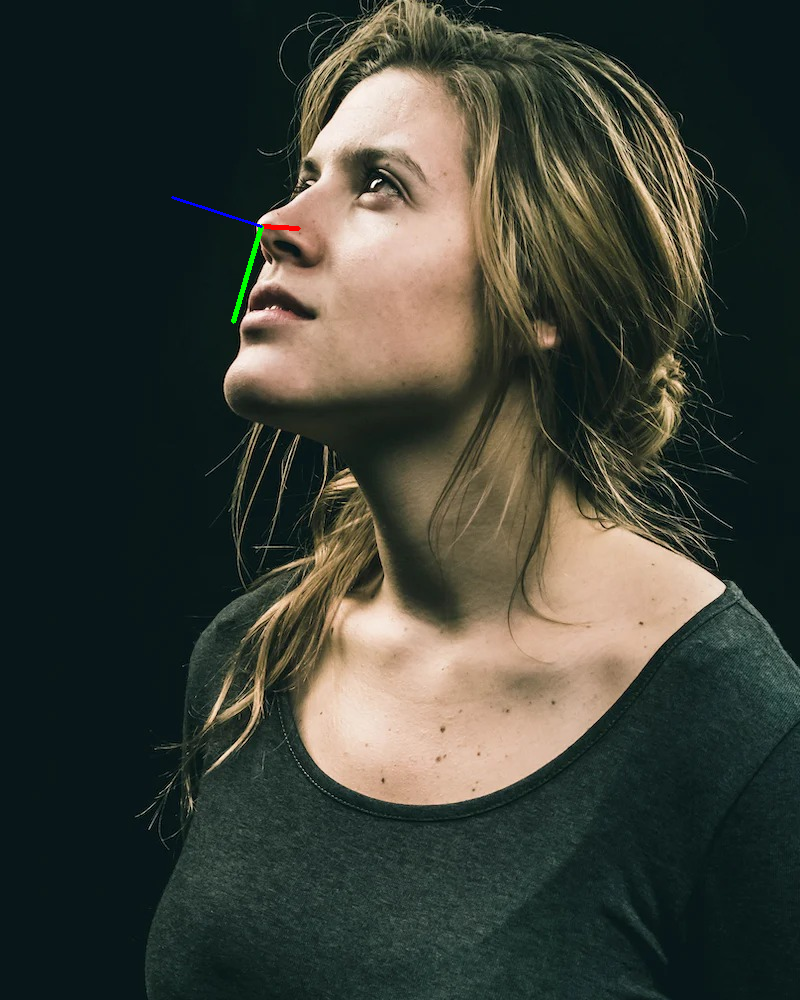

In [ ]:
predict_image('/content/pic.jfif', loaded_svm)

### Video

In [ ]:
def predict_video(PATH, model):

  """
  PATH : path of the video.
  model : model that will predict angles of the face in each frame.
  """

  # Load Video
  cap = cv2.VideoCapture(PATH)
  # Read first frame to extract width, height
  ret, frame = cap.read()
  height, width = frame.shape[:2]
  # VideoWriter object to save output of the model
  out = cv2.VideoWriter(PATH.split('/')[-1].split('.')[0]+'_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))


  while True:
      ret, frame = cap.read()
      if not ret:
          break

        # Extract features (landmarks) of the frame
      features = get_features(frame)

      # Check if features (landmarks) are detected 
      if features.size:
        features_df = pd.DataFrame(features, columns=X.columns)
        # Get X, Y coordinates of the nose
        nose = np.array(list(zip(features_df['X 1'], features_df['Y 1']))).squeeze()
        # Normalized features (landmarks) with respect to nose
        features_df = normalize_features(features_df)
        # Predict Pitch, Yaw and Roll angles
        pred = loaded_xgboost.predict(features_df.values).squeeze()
        # Draw axis on the frame
        draw_axis(frame, pred[0], pred[1], pred[2], tdx=nose[0], tdy=nose[1], size=50)
        # save the frame
        out.write(frame)

  # Release video
  out.release()
  cv2.destroyAllWindows()

In [ ]:
predict_video('/content/video.mp4', loaded_svm)